# Transfer Learning (CIFAR'10 DATASET) 
---

In [1]:
versioninfo() # -> v"1.11.1"

Julia Version 1.11.2
Commit 5e9a32e7af2 (2024-12-01 20:02 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 8 × Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz
  WORD_SIZE: 64
  LLVM: libLLVM-16.0.6 (ORCJIT, skylake)
Threads: 1 default, 0 interactive, 1 GC (on 8 virtual cores)
Environment:
  LD_LIBRARY_PATH = /home/mhamdi/torch/install/lib:/home/mhamdi/torch/install/lib:/home/mhamdi/torch/install/lib:
  DYLD_LIBRARY_PATH = /home/mhamdi/torch/install/lib:/home/mhamdi/torch/install/lib:/home/mhamdi/torch/install/lib:
  JULIA_NUM_THREADS = 8


In [2]:
using Pkg; pkg"activate ."; pkg"status"

  Activating project at `~/Work/git-repos/AI-ML-DL/jlai/Codes/Julia/Part-3/transfer-learning`


Status `~/Work/git-repos/AI-ML-DL/jlai/Codes/Julia/Part-3/transfer-learning/Project.toml`
  [88a5189c] DataAugmentation v0.3.2
⌅ [587475ba] Flux v0.14.25
  [4e3cecfd] ImageShow v0.3.8
  [916415d5] Images v0.26.1
  [eb30cadb] MLDatasets v0.7.18
  [dbeba491] Metalhead v0.9.4
  [c3e4b0f8] Pluto v0.20.4
  [7f904dfe] PlutoUI v0.7.60
  [d6f4376e] Markdown v1.11.0
Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated`


In [3]:
using Metalhead

Load the pre-trained model

[API Reference](https://fluxml.ai/Metalhead.jl/dev/api/reference/#API-Reference)

In [4]:
resnet = ResNet(18; pretrain=true).layers;

In [5]:
using Flux
using Flux: onecold, onehotbatch

In [6]:
mdl = Chain(
    resnet[1:end-1],
    resnet[end][1:end-1],
    # Replace the last layer
    Dense(512 => 256, relu),
    Dense(256 => 10)
)

Chain(
  Chain(
    Chain(
      Chain(
        Conv((7, 7), 3 => 64, pad=3, stride=2, bias=false),  # 9_408 parameters
        BatchNorm(64, relu),            # 128 parameters, plus 128
        MaxPool((3, 3), pad=1, stride=2),
      ),
      Chain(
        Parallel(
          addact(NNlib.relu, ...),
          identity,
          Chain(
            Conv((3, 3), 64 => 64, pad=1, bias=false),  # 36_864 parameters
            BatchNorm(64),              # 128 parameters, plus 128
            NNlib.relu,
            Conv((3, 3), 64 => 64, pad=1, bias=false),  # 36_864 parameters
            BatchNorm(64),              # 128 parameters, plus 128
          ),
        ),
        Parallel(
          addact(NNlib.relu, ...),
          identity,
          Chain(
            Conv((3, 3), 64 => 64, pad=1, bias=false),  # 36_864 parameters
            BatchNorm(64),              # 128 parameters, plus 128
            NNlib.relu,
            Conv((3, 3), 64 => 64, pad=1, bias=false),  # 36_864 par

Load the CIFAR10 dataset

In [7]:
using MLDatasets: CIFAR10

In [8]:
d = CIFAR10()

dataset CIFAR10:
  metadata  =>    Dict{String, Any} with 2 entries
  split     =>    :train
  features  =>    32×32×3×50000 Array{Float32, 4}
  targets   =>    50000-element Vector{Int64}

In [9]:
idx = rand(1:50000)

33582

In [10]:
using ImageShow

In [11]:
using MLDatasets: convert2image

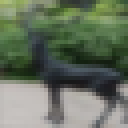

In [12]:
convert2image(d, idx)

In [13]:
printstyled("Label is $(d.targets[idx])"; bold=true, color=:red)

Label is 4

In [14]:
function get_data(split, lm::Integer=1024)
    data = CIFAR10(split)
    X, y = data.features[:, :, :, 1:lm] ./ 255, onehotbatch(data.targets[1:lm], 0:9)
    loader = Flux.DataLoader((X, y); batchsize=16, shuffle=true)
    return loader
end

get_data (generic function with 2 methods)

In [15]:
train_loader = get_data(:train, 512);
test_loader = get_data(:test, 128);

Define a setup of the optimizer

In [16]:
loss(X, y) = Flux.Losses.logitcrossentropy(mdl(X), y)
opt = Adam(3e-3)
ps = Flux.params(mdl[3:end])

Params([Float32[0.062949754 -0.0015656921 … 0.077504165 -0.03588768; -0.0037537669 -0.0647934 … 0.07406734 0.058980837; … ; -0.077901356 -0.0155950505 … -0.058319192 -0.05510754; 0.07489979 0.08095779 … -0.052442648 -0.004094387], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.026275884 -0.08689357 … -0.016626066 -0.023994584; 0.051166374 0.104917854 … -0.06314454 -0.063493095; … ; 0.08377673 -0.087479085 … -0.1303668 0.009646148; -0.10541802 -0.0024897186 … 0.079061404 -0.14347434], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

In [17]:
for epoch in 1:8
    Flux.train!(
        loss, 
        ps, 
        train_loader, 
        opt, 
        cb = Flux.throttle(() -> println("Training"), 10)
    )
end

Training
Training
Training
Training
Training
Training
Training
Training
Training
Training
Training
Training
Training
Training
Training
Training


In [18]:
sample = d.features[:, :, :, idx]
println(size(sample))
mb_sample = reshape(sample, 32, 32, 3, 1)
println(size(mb_sample))

(32, 32, 3)
, 32, 3, 1)


In [19]:
mdl(mb_sample) |> softmax |> onecold

1-element Vector{Int64}:
 5

In [20]:
#=
using Optimisers
opt_state = Optimisers.setup(Adam(3e-3), mdl[3:end]) # Freeze the weights of the pre-trained layers
using ProgressMeter
epochs = 5
# Fine-tune the model
for epoch in 1:epochs
    @showprogress for (X, y) in train_loader
        # Compute the gradient of the loss with respect to the model's parameters
        ∇ = Flux.gradient( m -> loss(m, X, y), mdl)
        # Update the `mdl`'s parameters
        Flux.update!(opt_state, mdl, ∇[1])
    end
    @info "Calculate the accuracy on the test set"
    for (X, y) in test_loader
        accuracy = sum(onecold(mdll(X)) .== onecold(y)) / length(y)
        println("Epoch: $epoch, Accuracy: $accuracy")
    end
end
=#